In [22]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\sbp_toy_abm")

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

from sbp_toy_abm.model import FLToyABM

%matplotlib inline

# Model initialization, step and collection of outputs

Import data on farmers and farms

In [24]:
farmers_data = ".\data\FarmersData.xlsx"
farms_data = ".\data\FarmsData.xlsx"

Provide payments for SBP adoption

In [25]:
# Give payments in €/hectare, one entry for each year 
sbp_payments = [50.72, 50.72, 51.82]
payments = {"Sown Permanent Pasture": sbp_payments}

Provide costs for pastures

In [26]:
pastures_costs = {"Sown Permanent Pasture": {
                    "installation": [-722.97],
                    "maintenance": [0.00, -135.96, 0.00, -318.27, 0.00,
                                    -135.96, 0.00, -318.27, 0.00]
                          },
                  'Natural Pasture': {
                      "installation": [0.],
                      "maintenance": [-235.40, -210.18, -210.18, -210.18,
                                      -210.18, -235.40, -210.18, -210.18, 
                                      -210.18]
                      }
                  }

Initialize and run one step

In [27]:
# Note that the model is initialized with a seed to have the same results
model = FLToyABM(payments, pastures_costs)

In [28]:
model.step()

Retrieve adoption at the farmer level

In [29]:
adoption_output = model.datacollector.get_agent_vars_dataframe()

In [30]:
final_adoption = adoption_output.loc[max(adoption_output.index.get_level_values(0).tolist())]
final_adoption = final_adoption.set_index('FARM_ID')
final_adoption.head()

,Farmer education,Pasture,Differential ENPV SBP
FARM_ID,,,
PT02,Undergraduate,Sown Permanent Pasture,90.837994
PT13,Undergraduate,Sown Permanent Pasture,90.837994
PT15,Undergraduate,Sown Permanent Pasture,90.837994
PT16,Undergraduate,Sown Permanent Pasture,90.837994
PT17,Undergraduate,Sown Permanent Pasture,90.837994


Retrieve adoption at the aggregated level

In [31]:
aggregate_adoption = model.datacollector.get_model_vars_dataframe()
aggregate_adoption

,Percentage of adoption
0,90.0


# Results analysis

<AxesSubplot:>

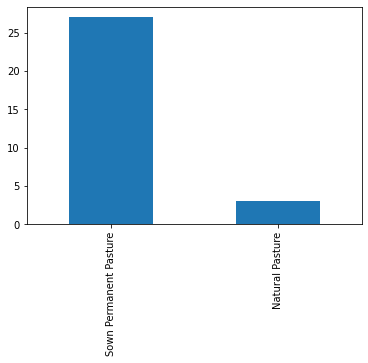

In [32]:
pd.value_counts(final_adoption['Pasture']).plot.bar()

In [33]:
final_adoption.groupby(['Farmer education']).mean('Differential ENVP SBP')

,Differential ENPV SBP
Farmer education,
Graduate,90.837994
Primary,-243.052488
Secondary,-76.107247
Undergraduate,90.837994


<AxesSubplot:xlabel='Farmer education'>

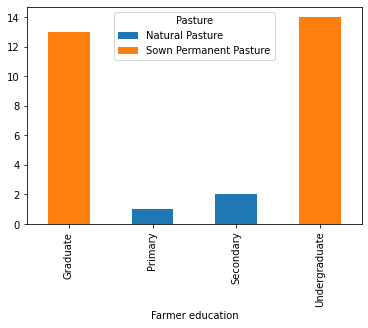

In [34]:
final_adoption.groupby('Farmer education')['Pasture'].value_counts().unstack().plot(kind='bar', stacked=True)

# Model validation

Get real adoption data

In [35]:
real_adoption_path = ".\data\FarmsDataValidation.xlsx"
real_adoption = pd.read_excel(real_adoption_path, index_col=0)
real_adoption.head()

,Pasture
FARM_ID,
PT02,Natural Pasture
PT13,Sown Permanent Pasture
PT15,Sown Permanent Pasture
PT16,Natural Pasture
PT17,Sown Permanent Pasture


<AxesSubplot:>

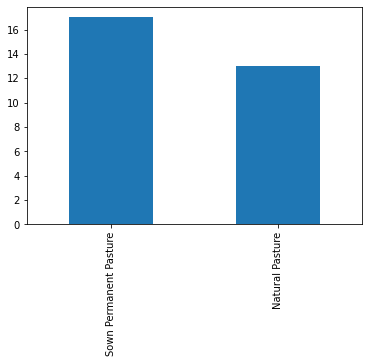

In [36]:
pd.value_counts(real_adoption['Pasture']).plot.bar()

## Micro-level validation

In [37]:
import sklearn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [38]:
pred_adoption = final_adoption['Pasture']

In [39]:
# Ordered in the right way: the first, Natural Pature, is considered the negative class
confusion_matrix(real_adoption, pred_adoption)

array([[ 2, 11],
       [ 1, 16]], dtype=int64)

In [40]:
print('Precision:', precision_score(real_adoption, pred_adoption, pos_label='Sown Permanent Pasture'))
print('Recall:', recall_score(real_adoption, pred_adoption, pos_label='Sown Permanent Pasture'))
print('F1 score:', f1_score(real_adoption, pred_adoption, pos_label='Sown Permanent Pasture'))

Precision: 0.5925925925925926
Recall: 0.9411764705882353
F1 score: 0.7272727272727272


## Macro-level validation

In [41]:
real_farmers_adopted = real_adoption['Pasture'].value_counts()['Sown Permanent Pasture']
real_percentage_adoption = real_farmers_adopted / len(real_adoption['Pasture'])*100
print(real_farmers_adopted, real_percentage_adoption)

17 56.666666666666664


In [42]:
modelled_percentage_adoption = aggregate_adoption.iloc[0, 0]
num_adopters = sum(pas == "Sown Permanent Pasture" for pas in final_adoption['Pasture'])
print(num_adopters, modelled_percentage_adoption)

27 90.0
